# Import dataset

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
from keras import optimizers, callbacks
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
image_width = 224
image_height = 224

from keras.applications.mobilenet import preprocess_input # correct preprocessing for this model

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

images_dir = "../../"
train_data_dir = images_dir + "train/"
val_data_dir = images_dir + "val/"
test_data_dir = images_dir + "test/"
batch_size = 64

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size=(image_width, image_height),
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   shuffle=True)

val_generator = val_datagen.flow_from_directory(val_data_dir,
                                               target_size=(image_width, image_height),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               shuffle=False)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=False)

Found 20 images belonging to 2 classes.
Found 6 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


# MobileNet base model for feature extraction

In [4]:
from keras.applications.mobilenet import MobileNet

base_model = MobileNet(input_shape=(image_height, image_width, 3),
                      include_top=False, # Leave off classifier layers, use it only as feature extractor
                      weights="imagenet",
                      pooling=None) # Leave off classifier layers, use it only as feature extractor

# Logistic regression for classification

In [11]:
num_classes = 2

from keras import regularizers
top_model = Sequential()
top_model.add(base_model)
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.001)))
top_model.add(Activation("softmax"))

for layer in base_model.layers:
    layer.trainable = False
    
top_model.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.Adam(lr=1e-3),
                 metrics=["accuracy"])

# Training

In [26]:
checkpoint_dir = "checkpoints_keras/"
checkpoint_name = (checkpoint_dir + "imageclassifier-{val_loss:.4f}-{val_acc:.4f}.hdf5")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
def create_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_acc",
                               patience=10,
                               verbose=1),
        callbacks.ModelCheckpoint(checkpoint_name,
                                 monitor="val_acc",
                                 verbose=1,
                                 save_best_only=True)
    ]

my_callbacks = create_callbacks()

In [27]:
histories = []

In [28]:
history = top_model.fit_generator(train_generator,
                                 steps_per_epoch=len(train_generator),
                                 epochs=10,
                                 callbacks=my_callbacks,
                                 validation_data=val_generator,
                                 validation_steps=len(val_generator),
                                 workers=8)
histories.append(history)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.2245 - acc: 0.5500 - val_loss: 0.5416 - val_acc: 0.8333

Epoch 00001: val_acc improved from -inf to 0.83333, saving model to checkpoints_keras/imageclassifier-0.5416-0.8333.hdf5
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.4203 - acc: 0.8000 - val_loss: 0.5534 - val_acc: 0.8333

Epoch 00002: val_acc did not improve from 0.83333
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.7667 - acc: 0.6500 - val_loss: 0.5675 - val_acc: 0.8333

Epoch 00003: val_acc did not improve from 0.83333
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.5582 - acc: 0.7000 - val_loss: 0.5949 - val_acc: 0.6667

Epoch 00004: val_acc did not improve from 0.83333
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.5019 - acc: 0.7000 - val_loss: 0.6100 - val_acc: 0.6667

Epoch 00005: val_acc did not improve from 0.83333
Epoch 6/10
1/1 [=======================

In [29]:
def combine_histories():
    history = {
        "loss": [],
        "val_loss": [],
        "acc": [],
        "val_acc": []
    }
    
    for h in histories:
        for k in history.keys():
            history[k] = h.history[k]
    return history

history = combine_histories()

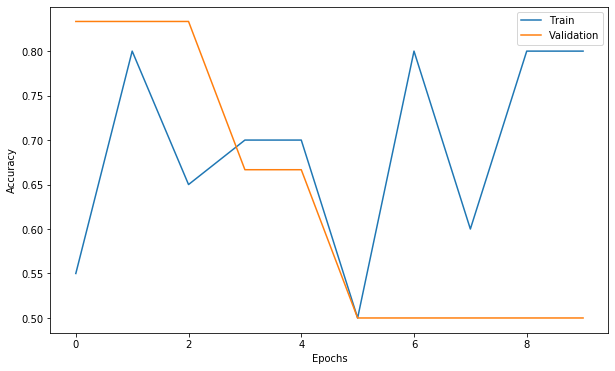

In [30]:
def plot_accuracy(history):
    fig = plt.figure(figsize=(10,6))
    plt.plot(history["acc"])
    plt.plot(history["val_acc"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])
    plt.show()

plot_accuracy(history)

# Testing

In [32]:
from keras.models import load_model
best_model = load_model(checkpoint_dir + "imageclassifier-0.5416-0.8333.hdf5")

In [33]:
best_model.evaluate_generator(test_generator,
                              steps=len(test_generator))

[0.2039228230714798, 1.0]

In [34]:
test_generator.reset()
probabilities = best_model.predict_generator(test_generator,
                                            steps=len(test_generator))
predicted_labels = np.argmax(probabilities, axis=-1)

In [35]:
target_labels = test_generator.classes

from sklearn import metrics
conf = metrics.confusion_matrix(target_labels, predicted_labels)

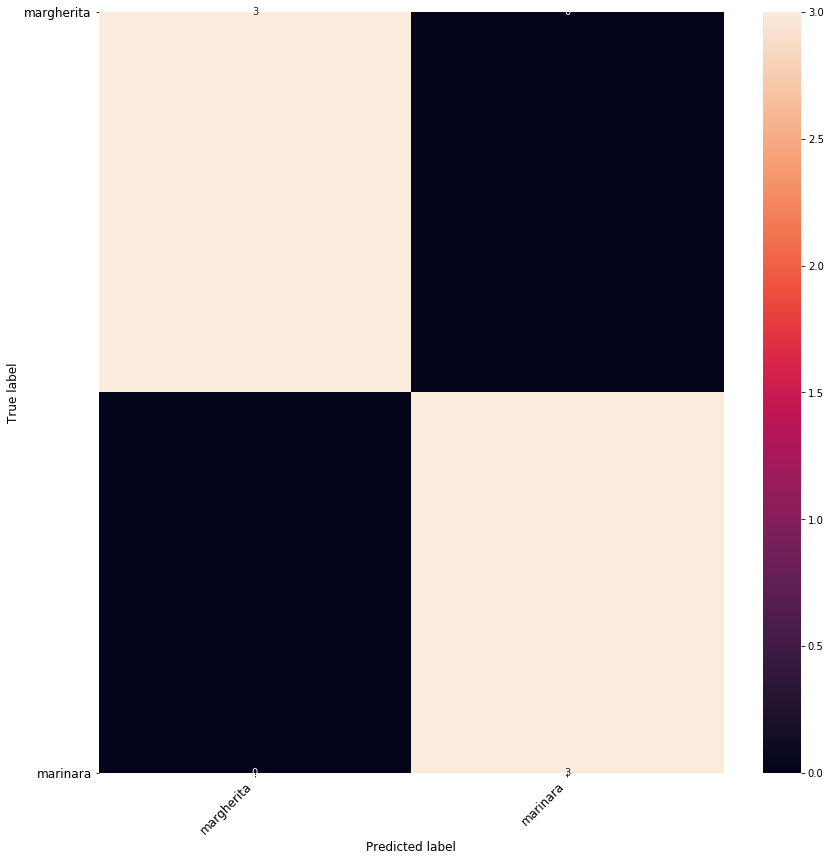

In [36]:
import seaborn as sns

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()
    
# Find the class names that correspond to the indices
labels = [""] * num_classes
for k, v in test_generator.class_indices.items():
    labels[v] = k
    
plot_confusion_matrix(conf, labels, figsize=(14, 14))

In [37]:
# Find for which images the predicted class is wrong
wrong_images = np.where(predicted_labels != target_labels)[0]

# For every prediction, find the largest probability value;
# this is the probability of the winning class for this image
probs_max = np.max(probabilities, axis=-1)

# Sort the probabilities from the wrong images from low to high
idx = np.argsort(probs_max[wrong_images])

# Reverse the order (high to low), and keep the 5 highest ones
idx = idx[::-1][:5]

# Get the indices of the images with the worst predictions
worst_predictions = wrong_images[idx]

index2class = {v:k for k,v in test_generator.class_indices.items()}

for i in worst_predictions:
    print("%s was predicted as '%s' %.4f" % (test_generator.filenames[i],
                                             index2class[predicted_labels[i]],
                                             probs_max[i]))

# Convertion

In [38]:
import coremltools

labels = ["apple", "banana", "cake", "candy", "carrot", "cookie", "doughnut", "grape", "hot dog", "ice cream",
         "juice", "muffin", "orange", "pineapple", "popcorn", "pretzel", "salad", "strawberry", "waffle", "watermelon"]

coreml_model = coremltools.converters.keras.convert(best_model,
                                                   input_names="image",
                                                   image_input_names="image",
                                                   output_names="labelProbability",
                                                   predicted_feature_name="label",
                                                   red_bias=-1, # normalization to interval [-1,+1]
                                                   green_bias=-1,
                                                   blue_bias=-1,
                                                   image_scale=2/255.0,
                                                   class_labels=labels)

coreml_model.author = "Antonio Chiappetta"
coreml_model.license = "Public Domain"
coreml_model.short_description = "Image classifier trained to distinguish 2 different types of pizza"
coreml_model.input_description["image"] = "Input image"
coreml_model.output_description["labelProbability"] = "Prediction probabilities"
coreml_model.output_description["label"] = "Class label of top prediction"

coreml_model.save("Pizza_keras.mlmodel")

0 : mobilenet_1.00_224_input, <keras.engine.input_layer.InputLayer object at 0x6586d1ac8>
1 : mobilenet_1.00_224_conv1_pad, <keras.layers.convolutional.ZeroPadding2D object at 0x6586aa198>
2 : mobilenet_1.00_224_conv1, <keras.layers.convolutional.Conv2D object at 0x6586aa1d0>
3 : mobilenet_1.00_224_conv1_bn, <keras.layers.normalization.BatchNormalization object at 0x6586aa278>
4 : mobilenet_1.00_224_conv1_relu, <keras.layers.advanced_activations.ReLU object at 0x6586aa438>
5 : mobilenet_1.00_224_conv_dw_1, <keras.layers.convolutional.DepthwiseConv2D object at 0x6586aa668>
6 : mobilenet_1.00_224_conv_dw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x6586aa6a0>
7 : mobilenet_1.00_224_conv_dw_1_relu, <keras.layers.advanced_activations.ReLU object at 0x6586aa710>
8 : mobilenet_1.00_224_conv_pw_1, <keras.layers.convolutional.Conv2D object at 0x6586aa9e8>
9 : mobilenet_1.00_224_conv_pw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x6586aaa20>
10 : mobilene

80 : mobilenet_1.00_224_conv_pw_12_relu, <keras.layers.advanced_activations.ReLU object at 0x6586d1438>
81 : mobilenet_1.00_224_conv_dw_13, <keras.layers.convolutional.DepthwiseConv2D object at 0x6586d1470>
82 : mobilenet_1.00_224_conv_dw_13_bn, <keras.layers.normalization.BatchNormalization object at 0x6586d14e0>
83 : mobilenet_1.00_224_conv_dw_13_relu, <keras.layers.advanced_activations.ReLU object at 0x6586d17b8>
84 : mobilenet_1.00_224_conv_pw_13, <keras.layers.convolutional.Conv2D object at 0x6586d17f0>
85 : mobilenet_1.00_224_conv_pw_13_bn, <keras.layers.normalization.BatchNormalization object at 0x6586d1978>
86 : mobilenet_1.00_224_conv_pw_13_relu, <keras.layers.advanced_activations.ReLU object at 0x6586d1a90>
87 : global_average_pooling2d_2, <keras.layers.pooling.GlobalAveragePooling2D object at 0x6586d1b70>
88 : dense_2, <keras.layers.core.Dense object at 0x65b40b9e8>
89 : activation_2, <keras.layers.core.Activation object at 0x65b3bffd0>
